In [10]:
import numpy as np
import pandas as pd
import subprocess
import os
import sys
import argparse
import glob
import time
from astropy.io import fits as pyfits
import matplotlib.pyplot as plt
from urllib.request import urlopen
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.time import Time
from contextlib import closing

ImportError: C extension: None not built. If you want to import pandas from the source directory, you may need to run 'python setup.py build_ext' to build the C extensions first.

In [2]:
# Load the CSV files
df1 = pd.read_csv("D:\summer_research_code\Query_VLASS_2\ia_supernovae_with_file_path.csv")  # First CSV with multiple instances
df2 = pd.read_csv("D:\summer_research_code\Query_VLASS_2\ia_supernovae_stuff\ia_full_data\ia_supernovae_with_start_jd.csv")  # Second CSV with start JD times


In [3]:
(df1['Date'].astype('string')[3118])

'Scheduled'

In [4]:
def convert_dates_to_jd(df, date_column):
    """
    Converts dates in a specified column of a DataFrame to Julian Date (JD).
    If conversion fails, assigns 'NA' (None) to the entry.

    Parameters:
    - df: The DataFrame containing the date column.
    - date_column: The name of the column containing dates in YYYY-MM-DD format.

    Returns:
    - The DataFrame with a new column 'JD' containing Julian Dates.
    """
    # Ensure the specified date column is in string format
    df[date_column] = df[date_column].astype(str)

    # Initialize a list to store Julian Dates
    jd_list = []

    # Loop through each date in the specified column and convert to JD
    for date in df[date_column]:
        try:
            jd = Time(date, format='iso').jd
            jd_list.append(jd)
        except Exception as e:
            jd_list.append(None)  # If conversion fails, append None (NA)

    # Add the new JD values as a new column
    df['JD'] = jd_list
    return df

In [5]:
df1 = convert_dates_to_jd(df1, 'Date')


In [6]:

def calculate_time_difference(df1, df2, date_column, startjd_column, merge_column_df1, merge_column_df2):
    """
    Calculates the time difference between the 'JD' in df1 and 'StartJD' in df2.

    Parameters:
    - df1: DataFrame with dates (containing 'JD' column).
    - df2: DataFrame with supernovae start times (containing 'StartJD' column).
    - date_column: The name of the date column in df1 that contains Julian Dates.
    - startjd_column: The name of the StartJD column in df2.
    - merge_column_df1: The name of the column in df1 to merge on (e.g., 'Name').
    - merge_column_df2: The name of the column in df2 to merge on (e.g., 'ZTFID').

    Returns:
    - The updated df1 with a new column 'Time Difference' in days.
    """
    # Merge the two DataFrames on the common columns ('Name' in df1 and 'ZTFID' in df2)
    merged_df = pd.merge(df1, df2, how='left', left_on=merge_column_df1, right_on=merge_column_df2)

    # Calculate the time difference between 'JD' in df1 and 'StartJD' in df2
    merged_df['Unedited DeltaT'] = merged_df[date_column] - merged_df[startjd_column]

    return merged_df


In [7]:
df = calculate_time_difference(df1, df2, 'JD', 'StartJD', 'Name', 'ZTFID')[['ZTFID', 'Ra_hourangle', 'Dec_degree', 'Epoch', 'File_path', 'redshift', 'Unedited DeltaT']]
df

,ZTFID,Ra_hourangle,Dec_degree,Epoch,File_path,redshift,Unedited DeltaT
0,ZTF18aahfbqp,10.445233,21.723917,VLASS1.2,ia_npy_arrays\ZTF18aahfbqp_VLASS1.2v2_array.npy,0.04136,-607.477326
1,ZTF18aahfbqp,10.445233,21.723917,VLASS2.2,ia_npy_arrays\ZTF18aahfbqp_VLASS2.2_array.npy,0.04136,350.522674
2,ZTF18aahfbqp,10.445233,21.723917,VLASS3.2,ia_npy_arrays\ZTF18aahfbqp_VLASS3.2_array.npy,0.04136,1230.522674
3,ZTF18aahfeiy,10.287656,43.523361,VLASS1.2,ia_npy_arrays\ZTF18aahfeiy_VLASS1.2v2_array.npy,0.07124,413.794745
4,ZTF18aahfeiy,10.287656,43.523361,VLASS2.2,ia_npy_arrays\ZTF18aahfeiy_VLASS2.2_array.npy,0.07124,1281.794745
...,...,...,...,...,...,...,...
9091,ZTF20acxmxth,23.194092,7.780361,VLASS2.1,ia_npy_arrays\ZTF20acxmxth_VLASS2.1_array.npy,0.04000,-125.094931
9092,ZTF20acxmxth,23.194092,7.780361,VLASS3.1,ia_npy_arrays\ZTF20acxmxth_VLASS3.1_array.npy,0.04000,811.905069
9093,ZTF20acxnafa,23.065981,30.724000,VLASS1.2,ia_npy_arrays\ZTF20acxnafa_VLASS1.2v2_array.npy,0.06000,-555.103380
9094,ZTF20acxnafa,23.065981,30.724000,VLASS2.2,ia_npy_arrays\ZTF20acxnafa_VLASS2.2_array.npy,0.06000,352.896620


In [8]:
# Constants
c = 3e5  # Speed of light in km/s
H0 = 70  # Hubble constant in km/s/Mpc

# Calculate Approximate Distance
df['Distance_Mpc'] = (c * df['redshift']) / H0

# Calculate Rest-Frame Time
df['Rest_DeltaT'] = df['Unedited DeltaT'] / (1 + df['redshift'])

df

,ZTFID,Ra_hourangle,Dec_degree,Epoch,File_path,redshift,Unedited DeltaT,Distance_Mpc,Rest_DeltaT
0,ZTF18aahfbqp,10.445233,21.723917,VLASS1.2,ia_npy_arrays\ZTF18aahfbqp_VLASS1.2v2_array.npy,0.04136,-607.477326,177.257143,-583.349972
1,ZTF18aahfbqp,10.445233,21.723917,VLASS2.2,ia_npy_arrays\ZTF18aahfbqp_VLASS2.2_array.npy,0.04136,350.522674,177.257143,336.600862
2,ZTF18aahfbqp,10.445233,21.723917,VLASS3.2,ia_npy_arrays\ZTF18aahfbqp_VLASS3.2_array.npy,0.04136,1230.522674,177.257143,1181.649644
3,ZTF18aahfeiy,10.287656,43.523361,VLASS1.2,ia_npy_arrays\ZTF18aahfeiy_VLASS1.2v2_array.npy,0.07124,413.794745,305.314286,386.276414
4,ZTF18aahfeiy,10.287656,43.523361,VLASS2.2,ia_npy_arrays\ZTF18aahfeiy_VLASS2.2_array.npy,0.07124,1281.794745,305.314286,1196.552356
...,...,...,...,...,...,...,...,...,...
9091,ZTF20acxmxth,23.194092,7.780361,VLASS2.1,ia_npy_arrays\ZTF20acxmxth_VLASS2.1_array.npy,0.04000,-125.094931,171.428571,-120.283587
9092,ZTF20acxmxth,23.194092,7.780361,VLASS3.1,ia_npy_arrays\ZTF20acxmxth_VLASS3.1_array.npy,0.04000,811.905069,171.428571,780.677951
9093,ZTF20acxnafa,23.065981,30.724000,VLASS1.2,ia_npy_arrays\ZTF20acxnafa_VLASS1.2v2_array.npy,0.06000,-555.103380,257.142857,-523.682434
9094,ZTF20acxnafa,23.065981,30.724000,VLASS2.2,ia_npy_arrays\ZTF20acxnafa_VLASS2.2_array.npy,0.06000,352.896620,257.142857,332.921340


In [9]:
def calculate_luminosity(flux, distance_mpc):
    """
    Calculate luminosity from flux and distance.

    Parameters:
    - flux (float or np.ndarray): Flux in Janskys.
    - distance_mpc (float): Distance in Megaparsecs.

    Returns:
    - np.ndarray: Luminosity in erg/s/Hz.
    """
    # Constants
    MPC_TO_CM = 3.0857e24  # 1 Mpc to cm
    JY_TO_ERG = 1e-23  # Jansky to erg/s/cm²/Hz
    FOUR_PI = 4 * np.pi

    # Convert flux to erg/s/cm²/Hz
    flux_erg = flux * JY_TO_ERG

    # Convert distance to cm
    distance_cm = distance_mpc * MPC_TO_CM

    # Calculate luminosity
    luminosity = FOUR_PI * (distance_cm ** 2) * flux_erg
    return luminosity

In [10]:
import os
import numpy as np
import pandas as pd
def process_and_save_luminosity(df, luminosity_folder):
    """
    Process flux arrays and save luminosities as NumPy files with a consistent naming format.

    Parameters:
    - df (pd.DataFrame): DataFrame containing flux file paths and distance information.
    - luminosity_folder (str): Folder path where luminosity files will be saved.

    Returns:
    - pd.DataFrame: Updated DataFrame with a new column for luminosity file paths.
    """
    # Ensure the luminosity folder exists
    os.makedirs(luminosity_folder, exist_ok=True)

    luminosity_file_paths = []

    for _, row in df.iterrows():
        # Check if File_path exists and is not NA
        if pd.isna(row['File_path']) or row['File_path'] == '':
            # Handle the case where the file path is missing
            print(f"Skipping row with missing 'File_path' for {row['ZTFID']}")
            luminosity_file_paths.append(np.nan)  # Or handle with a default value
            continue  # Skip the rest of the loop for this row

        # Build the flux file path
        flux_file = os.path.join('D:\\summer_research_code\\Query_VLASS_2', row['File_path'])

        # Generate the luminosity file name by inserting "luminosity" before "array"
        luminosity_file_name = row["File_path"].replace("array", "luminosity_array")
        
        # Ensure the luminosity file path is correct by removing folder part if repeated
        luminosity_file_name = os.path.basename(luminosity_file_name)  # Strip any leading path

        luminosity_file = os.path.join(luminosity_folder, luminosity_file_name)

        # If luminosity file doesn't exist, calculate and save it
        if not os.path.exists(luminosity_file):
            # Load the flux array
            flux_array = np.load(flux_file)

            # Calculate luminosity
            luminosity_array = calculate_luminosity(flux_array, row["Distance_Mpc"])

            # Save the luminosity array
            np.save(luminosity_file, luminosity_array)

        # Append the luminosity file path to the list
        luminosity_file_paths.append(luminosity_file)

    # Add a new column to the DataFrame
    df["Luminosity_File_Path"] = luminosity_file_paths

    return df


In [13]:
df_updated = process_and_save_luminosity(df, 'D:\\summer_research_code\\Query_VLASS_2\\ia_npy_luminosity_arrays')

Skipping row with missing 'File_path' for ZTF18acurfxn
Skipping row with missing 'File_path' for ZTF19aadpdqm
Skipping row with missing 'File_path' for ZTF19aadyoqz
Skipping row with missing 'File_path' for ZTF19aaraxhh
Skipping row with missing 'File_path' for ZTF19aaujzqh
Skipping row with missing 'File_path' for ZTF19aazlsfj
Skipping row with missing 'File_path' for ZTF19aazlsfj
Skipping row with missing 'File_path' for ZTF19aazlsfj
Skipping row with missing 'File_path' for ZTF19abhpvfq
Skipping row with missing 'File_path' for ZTF19abfvemi
Skipping row with missing 'File_path' for ZTF19abfvemi
Skipping row with missing 'File_path' for ZTF19abgsyrp
Skipping row with missing 'File_path' for ZTF19abyzuos
Skipping row with missing 'File_path' for ZTF19abyzuos
Skipping row with missing 'File_path' for ZTF19acazbqm
Skipping row with missing 'File_path' for ZTF19acbjddp
Skipping row with missing 'File_path' for ZTF19acygbye
Skipping row with missing 'File_path' for ZTF20aadzwnu
Skipping r

In [15]:
def process_array_for_rms(npy_array):

    try:
        # Load the NumPy array
        im = np.load(npy_array)

        # 3-sigma clipping (find the root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        return rms

    except Exception as e:
        print(f"An error occurred while processing the array: {e}")
        return None

In [16]:
df_updated['rms_values'] = df_updated['Luminosity_File_Path'].apply(process_array_for_rms)

C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\numpy\ma\core.py:5400: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = super().var(axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Jack Pope\AppData\Roaming\Python\Python39\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error occurred while processing the array: expected str, bytes or os.PathLike object, not float
An error o

In [ ]:
df

In [17]:
import numpy as np
import os

def weighted_stack(df, file_path_col="Luminosity_File_Path", rms_col="rms_values", expected_shape=(12, 12)):
    try:
        weighted_sum = None
        total_weight = 0
        
        # Lists to track issues
        bad_files = []  # General list of files with issues
        no_file = []     # Files that do not exist
        bad_shape = []   # Files with incorrect shapes
        no_rms = []      # Files with invalid RMS values

        for _, row in df.iterrows():
            ztfid = row.get("ZTFID", "Unknown")  # Use "Unknown" if not found
            epoch = row.get("Epoch", "Unknown")
            file_path = row[file_path_col]
            rms = row[rms_col]

            # Ensure file_path is a string and not NaN
            if not isinstance(file_path, str) or pd.isna(file_path):
                print(f"Skipping (ZTFID: {ztfid}, Epoch: {epoch}) - Invalid file path")
                no_file.append((ztfid, epoch))
                bad_files.append((ztfid, epoch))
                continue

            # Check if file exists
            if not os.path.exists(file_path):
                print(f"Skipping (ZTFID: {ztfid}, Epoch: {epoch}) - File not found")
                no_file.append((ztfid, epoch))
                bad_files.append((ztfid, epoch))
                continue

            # Load the NumPy array
            array = np.load(file_path)

            # Check array shape first
            if array.shape != expected_shape:
                print(f"Skipping (ZTFID: {ztfid}, Epoch: {epoch}) - Shape mismatch {array.shape}")
                bad_shape.append((ztfid, epoch))
                bad_files.append((ztfid, epoch))
                continue

            # Check if RMS is invalid
            if rms is None or rms <= 0 or np.isnan(rms):
                print(f"Skipping (ZTFID: {ztfid}, Epoch: {epoch}) - Invalid RMS ({rms})")
                no_rms.append((ztfid, epoch))
                bad_files.append((ztfid, epoch))
                continue

            # Calculate weight
            weight = 1 / (rms ** 2)

            # Accumulate weighted sum
            if weighted_sum is None:
                weighted_sum = array * weight
            else:
                weighted_sum += array * weight

            # Accumulate total weight
            total_weight += weight

        # Ensure total_weight is not zero to avoid division by zero
        if total_weight == 0:
            print("Total weight is zero. No valid data for stacking.")
            return None, bad_files, no_file, bad_shape, no_rms

        # Compute the final stacked array by normalizing
        stacked_array = weighted_sum / total_weight

        return stacked_array, bad_files, no_file, bad_shape, no_rms

    except Exception as e:
        print(f"An error occurred during stacking: {e}")
        return None, None, None, None, None

# Example usage
stacked_result, bad_files, no_file, bad_shape, no_rms = weighted_stack(df)

if stacked_result is not None:
    np.save("stacked_array.npy", stacked_result)
    print("Stacked array saved as 'stacked_array.npy'")
else:
    print("Stacking failed or no valid data.")

# Print lists of problematic files
if bad_files:
    print("\nThe following ZTFIDs and Epochs had issues and were skipped:")
    for ztfid, epoch in bad_files:
        print(f"ZTFID: {ztfid}, Epoch: {epoch}")

if no_file:
    print("\nMissing or invalid file paths for:")
    for ztfid, epoch in no_file:
        print(f"ZTFID: {ztfid}, Epoch: {epoch}")

if bad_shape:
    print("\nShape mismatches for:")
    for ztfid, epoch in bad_shape:
        print(f"ZTFID: {ztfid}, Epoch: {epoch}")

if no_rms:
    print("\nInvalid RMS values for:")
    for ztfid, epoch in no_rms:
        print(f"ZTFID: {ztfid}, Epoch: {epoch}")


Skipping (ZTFID: ZTF18aansqom, Epoch: VLASS1.1) - Shape mismatch (12, 0)
Skipping (ZTFID: ZTF18abddrhd, Epoch: VLASS2.1) - Shape mismatch (12, 11)
Skipping (ZTFID: ZTF18abdefet, Epoch: VLASS1.1) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18abdefet, Epoch: VLASS2.1) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18abdefet, Epoch: VLASS3.1) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18abiybfq, Epoch: VLASS1.1) - Shape mismatch (12, 0)
Skipping (ZTFID: ZTF18abiybfq, Epoch: VLASS2.1) - Shape mismatch (12, 0)
Skipping (ZTFID: ZTF18abiybfq, Epoch: VLASS3.1) - Shape mismatch (12, 0)
Skipping (ZTFID: ZTF18abjyuoj, Epoch: VLASS1.2) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18abjyuoj, Epoch: VLASS2.2) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18abjyuoj, Epoch: VLASS3.2) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18aboebsg, Epoch: VLASS1.1) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18aboebsg, Epoch: VLASS2.1) - Shape mismatch (0, 12)
Skipping (ZTFID: ZTF18aboebsg, Epoch: VLASS3.1) - 

In [18]:
stacked_result

array([[ 3.97066130e+23,  8.18435194e+24,  6.13805776e+24,
         4.98776436e+24,  1.99172153e+25,  1.69830067e+25,
         2.21518135e+24,  9.18840457e+24,  1.68329765e+25,
         6.26367245e+24, -1.91967429e+24,  5.89779241e+24],
       [-1.24656873e+24,  1.05353793e+25,  1.30899699e+25,
         1.98903490e+25,  2.29958000e+25,  1.05585536e+25,
         7.64832827e+24,  1.78798727e+25,  2.14786952e+25,
         1.63390312e+25,  4.99491690e+24,  4.10325960e+24],
       [-2.71108455e+24,  1.11554827e+25,  1.79847454e+25,
         2.58936405e+25,  2.91662118e+25,  1.46427693e+25,
         1.05917789e+25,  1.63187275e+25,  2.01325581e+25,
         1.55577701e+25,  9.55317018e+24,  7.87862112e+24],
       [ 4.99614739e+24,  1.91753453e+25,  2.56299475e+25,
         2.80074451e+25,  2.94187054e+25,  2.02356132e+25,
         1.53115704e+25,  1.33107985e+25,  1.21160900e+25,
         1.09684883e+25,  1.06151631e+25,  1.37455045e+25],
       [ 3.63944840e+24,  1.59240518e+25,  2.1727555

In [19]:
from pandasgui import show

show(df)


PandasGUI INFO — pandasgui.gui — Opening PandasGUI
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_9308\1218662979.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  show(df)
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_9308\1218662979.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  show(df)
C:\Users\Jack Pope\AppData\Local\Temp\ipykernel_9308\1218662979.py:3: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

C:\Users\Jack Pope\

Use for generic luminosity array

In [24]:
import numpy as np
import matplotlib.pyplot as plt

def luminosity_image_from_npy(npy_file, name, epoch, distance):
    try:
        # Load the image array from the .npy file
        im = np.load(npy_file)
        
        # Verify that the array is 2D
        if im.ndim != 2:
            print("Error: The input array must be 2D.")
            return None

        # 3-sigma clipping (find root mean square of values that are not above 3 standard deviations)
        rms_temp = np.ma.std(im)
        keep = np.ma.abs(im) <= 3 * rms_temp
        rms = np.ma.std(im[keep])

        # Find peak flux in entire image
        peak_flux = np.ma.max(im)

        # Plot the image (no need for WCS)
        fig, ax = plt.subplots(figsize=(6, 6))  # Create a square figure
        vmin = calculate_luminosity(-1e-4, distance)
        vmax = calculate_luminosity(1e-3, distance)
        ax.imshow(np.flipud(im), cmap='YlOrRd', vmin=vmin, vmax=vmax)
        print(f"vmin = {vmin}, vmax = {vmax}")

        peakstr = "Peak Flux %s " % (np.round(peak_flux, 3))
        rmsstr = "RMS Flux %s " % (np.round(rms, 3))

        title_str = r'$\bf{%s}$' % epoch + '\n' + '%s: %s;\n%s' % (name, peakstr, rmsstr)
        ax.set_title(title_str, fontsize=10)
        ax.set_xlabel("Offset in RA (arcsec)")
        ax.set_ylabel("Offset in Dec (arcsec)")

        ax.set_aspect('equal')  # Ensure the plot is square
        ax.figure.tight_layout()  # Adjust layout to fit everything nicely

    except Exception as e:
        print(f"An error occurred while processing {npy_file}: {e}")
        return None


Use for stacked array

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def luminosity_image_from_array(array, name, epoch, distance):
    try:
        # Ensure the array is 2D
        if array.ndim != 2:
            print(f"Error: The input array for {name}, Epoch {epoch} must be 2D.")
            return None

        # Compute robust min/max values for better scaling
        vmin, vmax = np.percentile(array, [5, 95])  # Exclude extreme outliers
        # Ensure a reasonable contrast
        if vmin == vmax:
            vmin, vmax = np.min(array), np.max(array)

        # Compute RMS using 3-sigma clipping
        rms_temp = np.std(array)
        keep = np.abs(array) <= 3 * rms_temp
        rms = np.std(array[keep])

        # Find peak flux
        peak_flux = np.max(array)

        # Plot image with adjusted scaling
        fig, ax = plt.subplots(figsize=(6, 6))
        img = ax.imshow(np.flipud(array), cmap='YlOrRd', vmin=vmin, vmax=vmax)

        # Format the title
        peakstr = f"Peak Flux: {np.round(peak_flux, 3)}"
        rmsstr = f"RMS Flux: {np.round(rms, 3)}"

        title_str = r'$\bf{%s}$' % epoch + '\n' + f'{name}; {peakstr}; {rmsstr}'
        ax.set_title(title_str, fontsize=10)

        ax.set_xlabel("Offset in RA (arcsec)")
        ax.set_ylabel("Offset in Dec (arcsec)")
        ax.set_aspect('equal')  # Keep square aspect ratio

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {name}, Epoch {epoch}: {e}")
        return None


In [93]:
df[df['ZTFID'] == 'ZTF17aadlxmv']

,ZTFID,Ra_hourangle,Dec_degree,Epoch,File_path,redshift,Unedited DeltaT,Distance_Mpc,Rest_DeltaT,Luminosity_File_Path,rms_values
27,ZTF17aadlxmv,8.496553,33.906333,VLASS1.2,ia_npy_arrays\ZTF17aadlxmv_VLASS1.2v2_array.npy,0.062,-253.35147,265.714286,-238.560706,D:\summer_research_code\Query_VLASS_2\ia_npy_l...,9.932944e+27
28,ZTF17aadlxmv,8.496553,33.906333,VLASS2.2,ia_npy_arrays\ZTF17aadlxmv_VLASS2.2_array.npy,0.062,688.64853,265.714286,648.444944,D:\summer_research_code\Query_VLASS_2\ia_npy_l...,9.207754e+27
29,ZTF17aadlxmv,8.496553,33.906333,VLASS3.2,ia_npy_arrays\ZTF17aadlxmv_VLASS3.2_array.npy,0.062,1639.64853,265.714286,1543.925170,D:\summer_research_code\Query_VLASS_2\ia_npy_l...,8.731816e+27


vmin = -8.438785849403401e+27, vmax = 8.438785849403402e+28


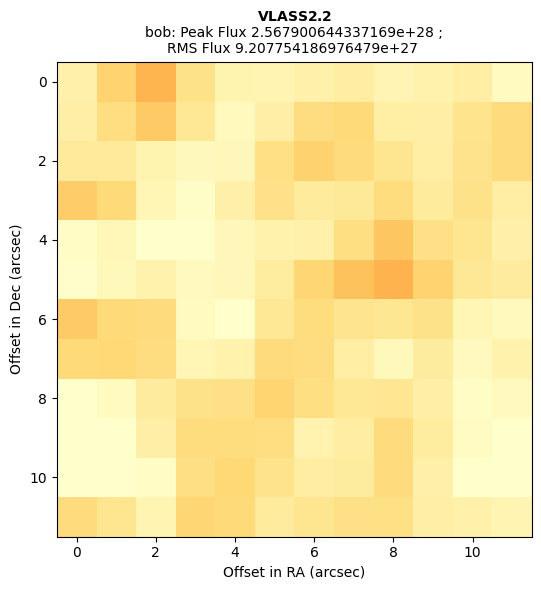

In [ ]:
luminosity_image_from_npy("D:\summer_research_code\Query_VLASS_2\ia_npy_luminosity_arrays\ZTF17aadlxmv_VLASS2.2_luminosity_array.npy", 'bob', 'VLASS2.2', 265.571429)

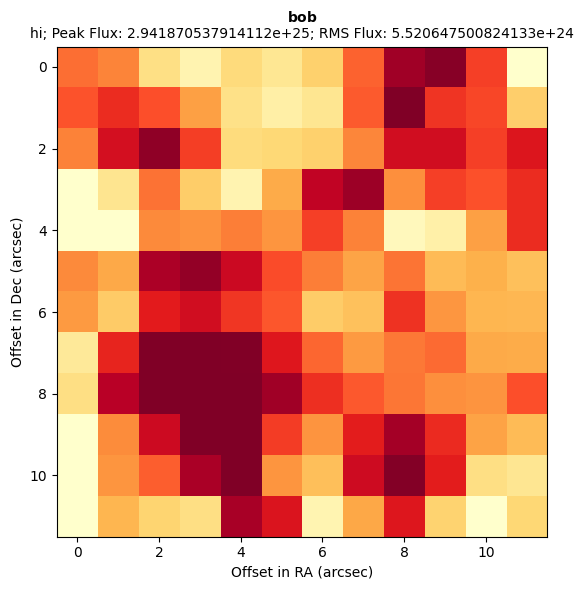

In [39]:
luminosity_image_from_array(stacked_result, 'hi','bob', 245)